In [1]:
from dwdbulk.api import forecasts, observations
from dwdbulk.util import get_stations_lookup
import pandas as pd

In [2]:
df_stations = get_stations_lookup()
berlin_stations = df_stations.loc[df_stations.state == "Berlin"]
forecast_berlin_station_ids = berlin_stations.forecasts_station_id.tolist()

# NOTE: TTTT = 2m Temperature (K)
df_forecast = forecasts.get_data(forecast_berlin_station_ids, parameters=["TTT"])

In [3]:
df_forecast["TT"] = df_forecast["TTT"] - 273
df_forecast.head()

date_start     TTT station_id product_id  \
0 2019-08-29 09:00:00+00:00  300.05       G002     MOSMIX   
1 2019-08-29 10:00:00+00:00  300.75       G002     MOSMIX   
2 2019-08-29 11:00:00+00:00  301.15       G002     MOSMIX   
3 2019-08-29 12:00:00+00:00  301.15       G002     MOSMIX   
4 2019-08-29 13:00:00+00:00  301.25       G002     MOSMIX   

               generating_process               date_issued     TT  
0  DWD MOSMIX hourly, Version 1.0 2019-08-29 08:00:00+00:00  27.05  
1  DWD MOSMIX hourly, Version 1.0 2019-08-29 08:00:00+00:00  27.75  
2  DWD MOSMIX hourly, Version 1.0 2019-08-29 08:00:00+00:00  28.15  
3  DWD MOSMIX hourly, Version 1.0 2019-08-29 08:00:00+00:00  28.15  
4  DWD MOSMIX hourly, Version 1.0 2019-08-29 08:00:00+00:00  28.25

In [4]:
date_end = pd.Timestamp.now(tz="UTC").floor("h")
date_start = date_end - pd.Timedelta("4 days")

observation_berlin_station_ids = berlin_stations.observations_station_id.tolist()
df_observation = observations.get_data(
    "air_temperature",
    station_ids=observation_berlin_station_ids,
    date_start=date_start,
    date_end=date_end,
    resolution="10_minutes",
)

In [5]:
df_observation.head()
df_observation["TT"] = df_observation["TT_10"]
df_observation["date_start_hour"] = df_observation["date_start"].dt.floor("h")
df_observation = df_observation.rename(columns={"station_id": "observations_station_id"})
df_observation_full = df_observation[["observations_station_id", "date_start", "date_start_hour", "TT"]]

In [6]:
df_forecast["hours_ahead"] = (df_forecast["date_start"] - df_forecast["date_issued"]) / pd.Timedelta('1 hour')
df_forecast["date_start_hour"] = df_forecast["date_start"].dt.floor("h")
df_forecast = df_forecast.rename(columns={"station_id": "forecasts_station_id"})
df_forecast_full = pd.merge(df_forecast, berlin_stations, on = "forecasts_station_id")
df_forecast_full = df_forecast_full[["observations_station_id", "date_start", "date_start_hour", "hours_ahead", "TT", "station_name", "state"]]

In [7]:
df_prediction_outcome = pd.merge(df_observation_full, df_forecast_full, on = ["observations_station_id", "date_start_hour"], suffixes=("_obs", "_fcst"))

In [8]:
df_prediction_outcome.head()

observations_station_id            date_start_obs           date_start_hour  \
0                   00400 2019-08-29 09:00:00+00:00 2019-08-29 09:00:00+00:00   
1                   00400 2019-08-29 09:10:00+00:00 2019-08-29 09:00:00+00:00   
2                   00400 2019-08-29 09:20:00+00:00 2019-08-29 09:00:00+00:00   
3                   00400 2019-08-29 09:30:00+00:00 2019-08-29 09:00:00+00:00   
4                   00400 2019-08-29 09:40:00+00:00 2019-08-29 09:00:00+00:00   

   TT_obs           date_start_fcst  hours_ahead  TT_fcst station_name   state  
0    26.5 2019-08-29 09:00:00+00:00          1.0    27.05  Berlin-Buch  Berlin  
1    27.0 2019-08-29 09:00:00+00:00          1.0    27.05  Berlin-Buch  Berlin  
2    27.3 2019-08-29 09:00:00+00:00          1.0    27.05  Berlin-Buch  Berlin  
3    27.5 2019-08-29 09:00:00+00:00          1.0    27.05  Berlin-Buch  Berlin  
4    27.5 2019-08-29 09:00:00+00:00          1.0    27.05  Berlin-Buch  Berlin

In [9]:
berlin_tempelhof = berlin_stations[berlin_stations.station_name == "Berlin-Tempelhof"]
berlin_tempelhof

observations_station_id forecasts_station_id      station_name   state
7                   00433                10384  Berlin-Tempelhof  Berlin

In [10]:
tempelhof_prediction_outcome = df_prediction_outcome.loc[df_prediction_outcome.observations_station_id == berlin_tempelhof.observations_station_id.iloc[0]]

In [11]:
tempelhof_prediction_outcome.head()

observations_station_id            date_start_obs  \
19458                   00433 2019-08-29 09:00:00+00:00   
19459                   00433 2019-08-29 09:10:00+00:00   
19460                   00433 2019-08-29 09:20:00+00:00   
19461                   00433 2019-08-29 09:30:00+00:00   
19462                   00433 2019-08-29 09:40:00+00:00   

                date_start_hour  TT_obs           date_start_fcst  \
19458 2019-08-29 09:00:00+00:00    27.5 2019-08-29 09:00:00+00:00   
19459 2019-08-29 09:00:00+00:00    28.1 2019-08-29 09:00:00+00:00   
19460 2019-08-29 09:00:00+00:00    28.2 2019-08-29 09:00:00+00:00   
19461 2019-08-29 09:00:00+00:00    28.5 2019-08-29 09:00:00+00:00   
19462 2019-08-29 09:00:00+00:00    28.1 2019-08-29 09:00:00+00:00   

       hours_ahead  TT_fcst      station_name   state  
19458          1.0    26.85  Berlin-Tempelhof  Berlin  
19459          1.0    26.85  Berlin-Tempelhof  Berlin  
19460          1.0    26.85  Berlin-Tempelhof  Berlin  
19461          1.0    26.85  Berlin-Tempelhof  Berlin  
19462          1.0    26.85  Berlin-Tempelhof  Berlin

In [12]:
import altair as alt
alt.data_transformers.disable_max_rows()

p_obs = alt.Chart(tempelhof_prediction_outcome).mark_line() \
    .encode(x=alt.X('date_start_obs:T', axis=alt.Axis(title="Date", grid=False)),            
            y="TT_obs")
p_obs_pts = alt.Chart(tempelhof_prediction_outcome).mark_point() \
    .encode(x="date_start_obs",
            y="TT_obs")


p_fcst = alt.Chart(tempelhof_prediction_outcome).mark_line() \
    .encode(x="date_start_obs",
            y=alt.Y("TT_fcst", axis=alt.Axis(title="°C"), scale=alt.Scale(zero=False)),
            color=alt.Color('hours_ahead:O', legend=alt.Legend(title="Forecast Hours Ahead"), scale=alt.Scale(scheme='purples'), sort="descending"))

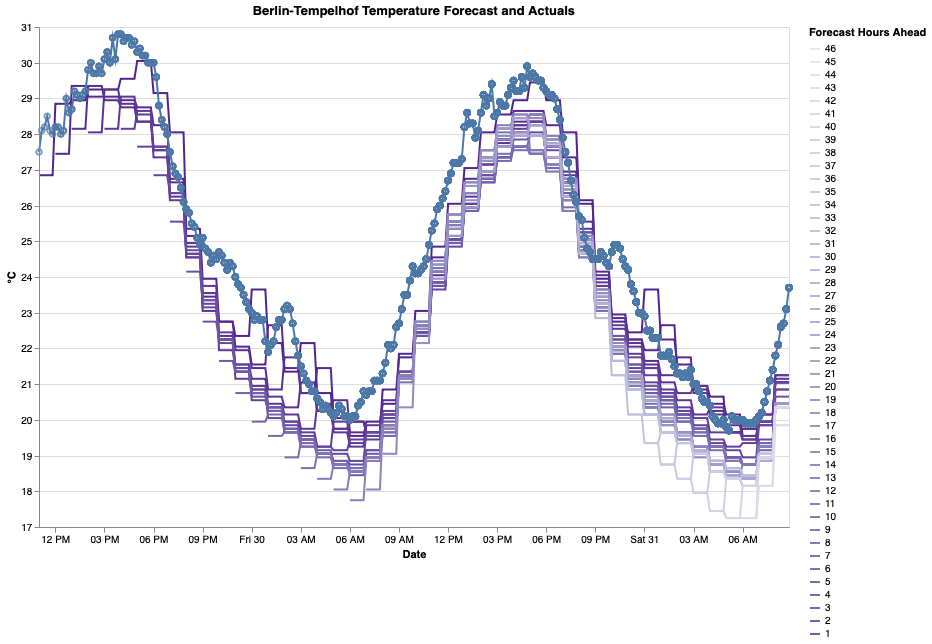

In [13]:
(p_fcst + p_obs + p_obs_pts) \
    .configure_view(height=500, width=750) \
    .properties(title="Berlin-Tempelhof Temperature Forecast and Actuals")

In [14]:
df_prediction_outcome["TT_error_deg_C"] = df_prediction_outcome["TT_fcst"] - df_prediction_outcome["TT_obs"]

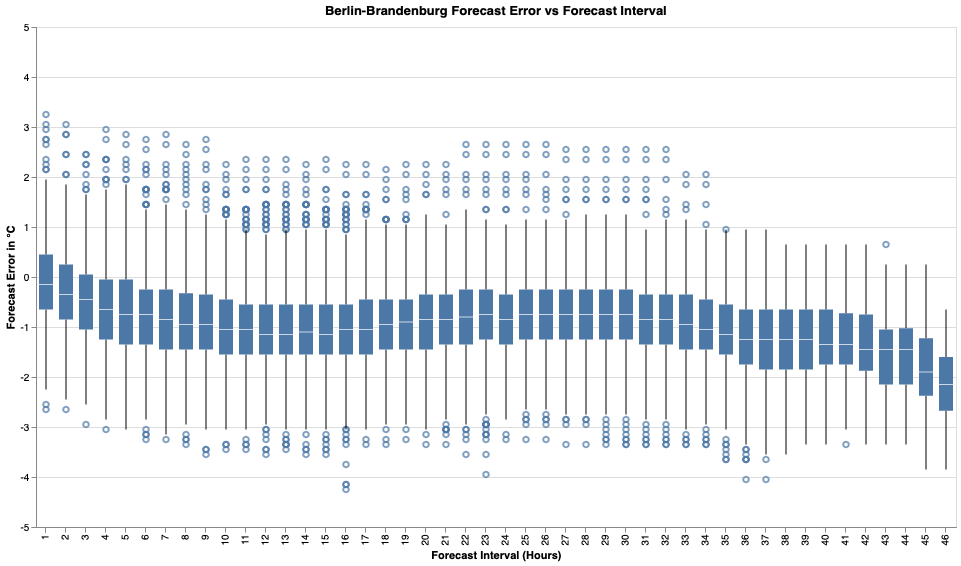

In [15]:
alt.Chart(df_prediction_outcome[["hours_ahead", "TT_error_deg_C"]]) \
    .mark_boxplot() \
    .encode(x = alt.X("hours_ahead:O", axis=alt.Axis(title="Forecast Interval (Hours)")),
            y = alt.Y("TT_error_deg_C:Q", axis=alt.Axis(title="Forecast Error in °C"), scale=alt.Scale(domain=[-5,5]))) \
    .configure_view(height=500, width=750) \
    .properties(title="Berlin-Brandenburg Forecast Error vs Forecast Interval")